<a href="https://colab.research.google.com/github/ethanarsht/detective-dogs/blob/Ethan/Ethan_Custom_Dataset_DataLoader_DataModule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Now that you know how to read in images, get their
# dimensions and visualize them, let's move on to working on
# our PyTorch dataset and COMPLETE THER EST

In [ ]:
# our FIRST step before we even get to building PyTorch objects
# is actually setting up a csv file that maps the file paths to
# their label and their category (i.e. train, val, test)

# one thing to consider here is the directory structure of chest_xray.
# within the chest_xray dir, there are three directories (train, val, test)
# and within those, there are two subdirectories (NORMAL, PNEUMONIA)

# scroll down to the __getitem___ part of our custom dataset and think
# about how you wanna handle your file paths before you construct your
# csv files!

# you might want to create 3 csv files (one for train, one for val, one
# for test) or you might have to just create 1 mega csv!
# totally up to you. Whatever you decide, you will have to adjust
# how you initialize your Dataset paramaeter (i.e. do you pass in the 
# path to the csv file? or a subset of a pandas df?)

# i'm gonna let you work some Pandas magic on your own! ;)

In [ ]:
# Now, that we got our csv file(s) and our images, we're finally
# ready to interact with PyTorch!

# At minimum, we'll implement three objects:
# - a custom Dataset object (PyTorch object)
# - your image transformations (augmentations!)
# - a DataLoader

# OPTIONAL: you can also implement 
# - a custom DataModule (PyTorch Lightning object)
#     * DataModule will use the DataLoader but the Module will
#     * nicely encapsulate other things like data augmentation!
#     * it's not a lot of work so I recommend it! It will make your life
#     * for checkpoint #2!

In [93]:
import os
import pandas as pd
from google.colab import drive

from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_image

In [94]:
# in implemting a custom PyTorch dataset you must implement
# three methods: __init__, __len__, and __getitem__

# a Dataset is indexable, which makes allows you index (duh)
# into your dataset, but also gives random access for 
# shuffling (which you can do yourself, or use a DataLoader, or
# use a DataModule)

# for more help: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir_path, transform=None):
        """
        You can set your custom dataset to take in more parameters than specified
        here. But, I recommend at least you start with the three I listed here,
        as these are standard

        csv_file (str): file path to the csv file you created /
        df (pandas df): pandas dataframe

        img_dir_path: directory path to your images
        transform: Compose (a PyTorch Class) that strings together several
          transform functions (e.g. data augmentation steps)

        One thing to note -- you technically could implement `transform` within
        the dataset. No one is going to stop you, but you can think of the
        transformations/augmentations you do as a hyperparameter. If you treat
        it as a hyperparameter, you want to be able to experiment with different
        transformations, and therefore, it would make more sense to decide those
        transformations outside the dataset class and pass it to the dataset!
        """
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir_path
        self.transform = transform

    def __len__(self):
        """
        Returns: (int) length of your dataset
        """

        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Loads and returns your sample (the image and the label) at the
        specified index

        Parameter: idx (int): index of interest

        Returns: image, label
        """

        # think about how you wanna handle the image path
        # re: making your own csv files! 
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, label

In [95]:
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [230]:
# implementing your transformations

# for additional help: https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose

# for a list of transformations illustrated: 
# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

# NOTE: per PyTorch, 
"""
Most transformations accept both PIL images and tensor images,
although some transformations are PIL-only and some are tensor-only.
"""

# therefore, you will have to experiment with what works with your image!
# or read the documentation!

import torchvision.transforms as T

# mean_width = 1424.1973954763537
# mean_height = 1061.5017135023988

transforms = T.Compose(
    [
        # if you are using cv2, you will need to FIRST convert
        # the image to a Tensor. if you are using PIL to read in your image
        # you will need to convert uit to a Tensor eventually!
     
        T.RandomAdjustSharpness(sharpness_factor=2),
        T.RandomPosterize(bits=4, p=0.5),
        T.ColorJitter(brightness = (0,.2), contrast = (0,.2), saturation = (0,.2),
                      hue = (0,.2)
                      ),
        T.RandomAutocontrast(p = .5)
        # T.Resize((mean_width, mean_height))
        
        # this is just an example. I randomly selected some.
        # Choose your own more carefully! :)
        # you will definitely want to RESIZE your image! if you don't want to
        # decide on a size yet, you can return to resizing for checkpoint #2 when
        # we implement our custom model!

        # if you are normalizing your image, you will need to consider two things
     
        # 1) if you are using a pre-trained model, you will use the mean and SD
        # of the data that model was trained on
        # (this does not apply to us yet or ever, depending on what you do for the
        # final part of the project)

        # 2) if you are using a custom model, you will need to normalize your images
        # based on the mean and SD of your TRAINING data
        # and you will have to normalize your validation and your test data, too
        # using your training data's mean and SD
     
        # this brings us to another good point to consider -- you might have to
        # prepare two transformations for your datasets 
        # your augmentation transform for your training data, which will normalize
        # (if you're doing that), distort and resize the image
        # one that just normalizes (if you're doing that) and resizes
        # your validation and testing data
     
        # LOTS TO THINK ABOUT <3 
    ]
)

In [231]:
# building your DataLoaders

# here we can more directly see how the dataset interacts wiht the dataloader
# the dataloader really is just an iterator. it's not very "smart"
# it's not going to give you validation data just because you named it val_dataloader
# so the distinction will need to happen when you create val_data, which means that
# you need to either build in an mechanism internally in the CustomImageDataset to 
# parse for `valid` category inside the csv (if you are just providing the file path
# to a mega csv) or you can pass it an already subsetted csv or df!

training_data = CustomImageDataset('drive/MyDrive/pneumonia_images/train/train.csv', 
                                   'drive/MyDrive/pneumonia_images/train/train_images', 
                                   transforms)
val_data = CustomImageDataset('drive/MyDrive/pneumonia_images/val/val.csv', 
                              'drive/MyDrive/pneumonia_images/val/val_images', 
                               transforms)
test_data = CustomImageDataset('drive/MyDrive/pneumonia_images/test/test.csv', 
                              'drive/MyDrive/pneumonia_images/test/test_images', 
                               transforms)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [232]:
len(training_data)

5216

In [233]:
train_dataloader

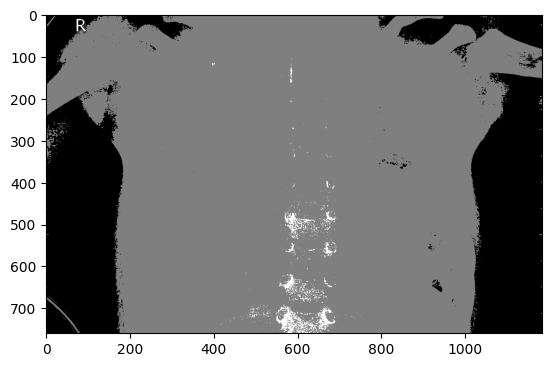

In [234]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming training_data is a 3D tensor with shape (a, b, c)
tensor_2d = training_data[1][0][0,:,:]

# Plot the resulting 2D tensor
plt.imshow(tensor_2d, cmap='gray')
plt.show()

In [102]:

tensor_2d

tensor([[ 0, 17, 17,  ..., 50, 50, 50],
        [ 0, 17, 17,  ..., 50, 50, 50],
        [ 0, 17, 17,  ..., 50, 50, 50],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]], dtype=torch.uint8)